# Data Sourcing

This code queries the GitHub Code Search API to identify open-source repositories that likely use LLM-based tooling, patterns, or frameworks.

We define a curated list of **LLM-related keywords** covering:

* OpenAI API usage (`openai.ChatCompletion.create`)
* Prompting structures (`"prompt = "`, `"system":`)
* Frameworks like LangChain, llama.cpp, AutoGPT
* Retrieval-augmented generation libraries (e.g., FAISS, Chroma)

For each keyword, we retrieve up to **`max_pages × per_page`** results from GitHub’s Code Search API, filtering for Python files. Each result is a code file matched to the keyword, and we collect the:

* **Repository name**
* **File path**
* **URL to the matching file**
* **Matching keyword**

These are grouped by repository. For each repository, we track:

* All matched keywords (as a signal of LLM usage diversity)
* All matching file paths and URLs

This allows us to:

* **Filter for repositories with stronger LLM relevance** (based on keyword match count)
* Generate a dataset of repositories likely to contain rich prompt engineering artifacts

The final output is saved to:

* `data/matched_repositories.csv` (tabular)
* `data/matched_repositories.json` (structured)


In [4]:
# Check and install required packages
import sys
import subprocess

def install_if_missing(package, import_name=None):
    try:
        __import__(import_name or package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Required packages
install_if_missing("requests")
install_if_missing("pandas")
install_if_missing("python-dotenv", import_name="dotenv")

Installing python-dotenv...
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)


In [6]:
import requests
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import os
import json
import time

# Load environment variables (e.g., GitHub token)
load_dotenv()
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")

# GitHub Search API endpoint
SEARCH_URL = "https://api.github.com/search/code"

# Expanded list of LLM-related keywords
keywords = [
    "openai.ChatCompletion.create", "openai.Completion.create",
    "PromptTemplate", "LLMChain", "ConversationChain", "RetrievalQA",
    "from langchain.llms", "from langchain.chat_models",
    "llama_cpp", "llamacpp", "llm.predict",
    "\"prompt = \"", "\"prompt=\"", "\"prompt\": \"", "\"system\": \"",
    "AutoGPT", "CrewAI", "AgentGPT", "BabyAGI",
    "ChatOpenAI", "Anthropic", "Claude", "HuggingFaceHub", "transformers.pipeline",
    "FAISS", "Chroma", "vectordb"
]

# GitHub headers
headers = {"Accept": "application/vnd.github.v3+json"}
if GITHUB_TOKEN:
    headers["Authorization"] = f"token {GITHUB_TOKEN}"

# Output paths
csv_path = Path("..") / "data" / "matched_repositories.csv"
json_path = Path("..") / "data" / "matched_repositories.json"
csv_path.parent.mkdir(parents=True, exist_ok=True)

# Store results per repository
repo_matches = {}

# Search GitHub for each keyword
max_pages = 5  # You can increase this to 10 (500 results per keyword max)
per_page = 50

for keyword in keywords:
    print(f"\n=== Searching for: {keyword} ===")
    for page in range(1, max_pages + 1):
        print(f"Page {page}")
        params = {
            "q": f"{keyword} in:file language:Python",
            "sort": "indexed",
            "order": "desc",
            "per_page": per_page,
            "page": page
        }
        try:
            r = requests.get(SEARCH_URL, headers=headers, params=params)
            r.raise_for_status()

            # Respect the 30-requests-per-minute limit
            remaining = int(r.headers.get("X-RateLimit-Remaining", 1))
            if remaining < 2:
                reset_time = int(r.headers.get("X-RateLimit-Reset", 0))
                sleep_for = max(1, reset_time - int(time.time()))
                print(f"Rate limit reached, sleeping for {sleep_for} s")
                time.sleep(sleep_for + 1)
            else:
                time.sleep(2)

            data = r.json()
            if not data.get("items"):
                print("No more results.")
                break

            for item in data["items"]:
                repo = item["repository"]["full_name"]
                if repo not in repo_matches:
                    repo_matches[repo] = {
                        "repository": repo,
                        "html_urls": set(),
                        "file_paths": set(),
                        "keywords": set()
                    }
                repo_matches[repo]["html_urls"].add(item["html_url"])
                repo_matches[repo]["file_paths"].add(item["path"])
                repo_matches[repo]["keywords"].add(keyword)

        except requests.exceptions.RequestException as e:
            print(f"Failed for {keyword} page {page}: {e}")
            break

# Flatten to DataFrame
records = []
for repo_data in repo_matches.values():
    records.append({
        "repository": repo_data["repository"],
        "keyword_count": len(repo_data["keywords"]),
        "keywords_matched": sorted(repo_data["keywords"]),
        "files_matched": sorted(repo_data["file_paths"]),
        "sample_urls": sorted(repo_data["html_urls"])[:3]
    })

df = pd.DataFrame(records).sort_values(by="keyword_count", ascending=False)

# Save CSV and JSON
df.to_csv(csv_path, index=False)
df.to_json(json_path, orient="records", indent=2)

# Summary
print(f"\nSaved {len(df)} repositories grouped by relevance:")
print(f"- CSV: {csv_path}")
print(f"- JSON: {json_path}")

# Display top matches
df[["repository", "keyword_count", "keywords_matched"]].head(10)




=== Searching for: openai.ChatCompletion.create ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: openai.Completion.create ===
Page 1
Page 2
Page 3
Page 4
Rate limit reached, sleeping for 40 s
Page 5

=== Searching for: PromptTemplate ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: LLMChain ===
Page 1
Page 2
Page 3
Rate limit reached, sleeping for 38 s
Page 4
Page 5

=== Searching for: ConversationChain ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: RetrievalQA ===
Page 1
Page 2
Rate limit reached, sleeping for 39 s
Page 3
Page 4
Page 5

=== Searching for: from langchain.llms ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: from langchain.chat_models ===
Page 1
Rate limit reached, sleeping for 38 s
Page 2
Page 3
Page 4
Page 5

=== Searching for: llama_cpp ===
Page 1
Page 2
Page 3
Page 4
Page 5
Rate limit reached, sleeping for 38 s

=== Searching for: llamacpp ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: llm.predict ===
Page 1
Pag

,repository,keyword_count,keywords_matched
756,hidevscommunity/gen-ai-apps,5,"[AutoGPT, HuggingFaceHub, LLMChain, RetrievalQ..."
652,ayusuf9/Augment-Chains,4,"[FAISS, PromptTemplate, RetrievalQA, from lang..."
604,jaredcrace/cracecasts,4,"[Chroma, LLMChain, PromptTemplate, llamacpp]"
1692,himanshu662000/InfoGPT,4,"[ChatOpenAI, Chroma, from langchain.chat_model..."
65,amaze18/speeKAR,4,"[FAISS, from langchain.chat_models, from langc..."
3713,scodecs/conversational-search-app,4,"[ChatOpenAI, FAISS, HuggingFaceHub, vectordb]"
609,aws-samples/private-llm-qa-bot,4,"[Anthropic, Claude, LLMChain, PromptTemplate]"
1277,frankstallone/notion-qa,4,"[ChatOpenAI, FAISS, RetrievalQA, from langchai..."
28,Tech-Abhang/LangChain-Basics,4,"[LLMChain, RetrievalQA, from langchain.chat_mo..."
1421,kingly123/My_AI,4,"[FAISS, HuggingFaceHub, from langchain.chat_mo..."


### Extra: Keyword count analysis

Repositories by number of matched keywords:

1 keyword(s): 4763 repository(ies)
2 keyword(s): 407 repository(ies)
3 keyword(s): 62 repository(ies)
4 keyword(s): 23 repository(ies)
5 keyword(s): 1 repository(ies)


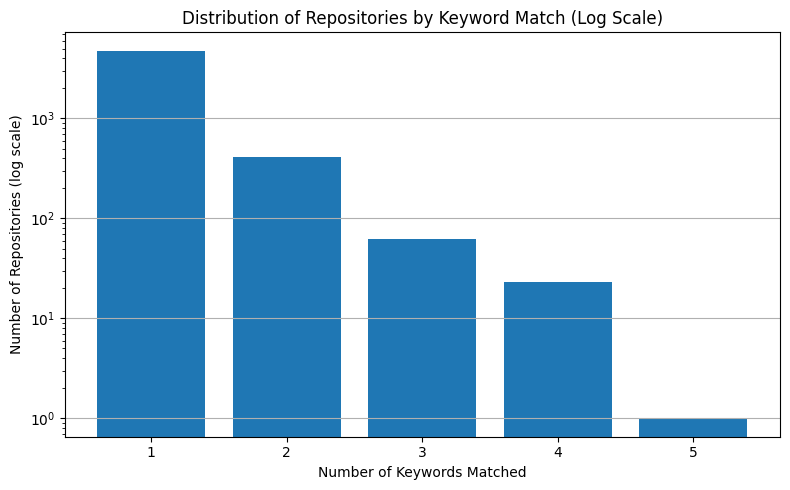

In [10]:
import matplotlib.pyplot as plt

# Count number of repositories per keyword_count category
keyword_count_distribution = df["keyword_count"].value_counts().sort_index()

# Print distribution
print("Repositories by number of matched keywords:\n")
for count, num_repos in keyword_count_distribution.items():
    print(f"{count} keyword(s): {num_repos} repository(ies)")

plt.figure(figsize=(8, 5))
df["keyword_count"].plot(
    kind="hist",
    bins=range(1, df["keyword_count"].max() + 2),
    rwidth=0.8,
    align="left",
    log=True  # Log scale
)
plt.title("Distribution of Repositories by Keyword Match (Log Scale)")
plt.xlabel("Number of Keywords Matched")
plt.ylabel("Number of Repositories (log scale)")
plt.xticks(range(1, df["keyword_count"].max() + 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()



## Metadata Collection

The next step is to enrich these repositories with basic project-level metadata. The goal is to better understand the characteristics of each repository and enable informed filtering or stratification prior to deeper prompt analysis.

This step retrieves public metadata for each repository in our initial dataset, including:

* **Popularity indicators**:

  * Star count
  * Fork count
  * Watcher count

* **Project activity indicators**:

  * Open issue count
  * Recent push/update timestamps
  * Default branch name
  * Language and license info

* **Basic descriptions**:

  * Project summary
  * Creation date
  * GitHub URL

These features help determine which repositories are actively maintained, widely used, or potentially worth deeper inspection (e.g. via commit history or prompt extraction).


In [16]:
import os
import json
import time
import requests
import pandas as pd
from dotenv import load_dotenv

# Load GitHub token
load_dotenv()
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")

# Load previously matched repositories
with open("../data/matched_repositories.json", "r") as f:
    matched_repos = json.load(f)

# Set up GitHub API headers
headers = {"Accept": "application/vnd.github.v3+json"}
if GITHUB_TOKEN:
    headers["Authorization"] = f"token {GITHUB_TOKEN}"

# Extract unique repo names
repo_names = sorted(set(repo["repository"] for repo in matched_repos))

# Store metadata
repo_metadata = []

for i, repo_full_name in enumerate(repo_names, start=1):
    print(f"[{i}/{len(repo_names)}] Getting metadata for: {repo_full_name}")
    url = f"https://api.github.com/repos/{repo_full_name}"
    try:
        r = requests.get(url, headers=headers)
        r.raise_for_status()
        data = r.json()
        repo_metadata.append({
            "repository": repo_full_name,
            "description": data.get("description"),
            "stars": data.get("stargazers_count"),
            "forks": data.get("forks_count"),
            "watchers": data.get("subscribers_count"),
            "open_issues": data.get("open_issues_count"),
            "default_branch": data.get("default_branch"),
            "created_at": data.get("created_at"),
            "updated_at": data.get("updated_at"),
            "pushed_at": data.get("pushed_at"),
            "language": data.get("language"),
            "license": data.get("license", {}).get("name") if data.get("license") else None,
            "html_url": data.get("html_url")
        })

        # Respect rate limit
        remaining = int(r.headers.get("X-RateLimit-Remaining", 1))
        if remaining < 2:
            reset_time = int(r.headers.get("X-RateLimit-Reset", 0))
            sleep_for = max(1, reset_time - time.time())
            print(f"Rate limit approaching, sleeping for {sleep_for:.1f}s...")
            time.sleep(sleep_for + 1)

    except requests.RequestException as e:
        print(f"Failed for {repo_full_name}: {e}")


# Save results
df = pd.DataFrame(repo_metadata)
df.to_csv("../data/repo_metadata.csv", index=False)
df.to_json("../data/repo_metadata.json", orient="records", indent=2)

print(f"\nSaved metadata for {len(df)} repositories:")
print("- CSV: ../data/repo_metadata.csv")
print("- JSON: ../data/repo_metadata.json")


[1/5256] Getting metadata for: 007ekho/mew_chroma_sentence
[2/5256] Getting metadata for: 0152neich/Chatbot_CV
[3/5256] Getting metadata for: 060205b/langchain-nutrition-agent-with-observability
[4/5256] Getting metadata for: 0ldev/macroscopIA
[5/5256] Getting metadata for: 0ssamaak0/CLIPPyX
[6/5256] Getting metadata for: 0ssamaak0/SiriLLama
[7/5256] Getting metadata for: 0x4D5352/honeyBOT
[8/5256] Getting metadata for: 0xLazAI/alith
[9/5256] Getting metadata for: 0xfzyy/My_ai
[10/5256] Getting metadata for: 0xnogo/sawadee-backend
[11/5256] Getting metadata for: 100-hours-a-week/11-ellu-ai-summary-service
[12/5256] Getting metadata for: 100percentBAKA/poc-dump
[13/5256] Getting metadata for: 100x-Engineers100/Discord_V3
[14/5256] Getting metadata for: 1160-hrk/lab-ai-agent
[15/5256] Getting metadata for: 124135417/GPT
[16/5256] Getting metadata for: 13331112522/m-rag
[17/5256] Getting metadata for: 17-Jarvis/Chatbots
[18/5256] Getting metadata for: 1Back-end/HIREGENIUS-API-
[19/5256] G

## Merging Keyword Match Results with Repository Metadata

After collecting the two separate datasets — one with repositories matched by LLM-related keyword occurrences (`keyword_count`, `keywords_matched`, etc.), and another with general repository metadata (`stars`, `forks`, `issues`, etc.) — we merged the two on the common `repository` identifier.

This step was necessary to:

* **Unify prompt relevance signals** (via keyword matches)
  with
* **Project-level indicators** of engagement and activity (via GitHub metadata)

The merged dataset provides a comprehensive view of each repository, allowing us to sort, filter, and eventually select a diverse and relevant sample space for further analysis.

Both datasets used `repository` as a consistent unique key in the format `owner/repo-name`, which ensured a clean one-to-one merge without duplication. The final combined dataset is saved in both `.csv` and `.json` format for reproducibility and downstream processing.


In [19]:
import pandas as pd
from pathlib import Path
import json

# Load the keyword match data
with open(Path("..") / "data" / "matched_repositories.json", "r") as f:
    keyword_data = json.load(f)

# Load the repository metadata
with open(Path("..") / "data" / "repo_metadata.json", "r") as f:
    metadata = json.load(f)

# Convert to DataFrames
df_keywords = pd.DataFrame(keyword_data)
df_metadata = pd.DataFrame(metadata)

# Merge on repository name (repo full_name)
df_combined = pd.merge(
    df_keywords,
    df_metadata,
    how="inner",
    on="repository"
)


# # Drop any duplicate or redundant columns
# df_combined = df_combined.drop(columns=["full_name"])

# Save combined output
output_path_csv = Path("..") / "data" / "combined_repository_data.csv"
output_path_json = Path("..") / "data" / "combined_repository_data.json"

df_combined.to_csv(output_path_csv, index=False)
df_combined.to_json(output_path_json, orient="records", indent=2)

print(f"Merged dataset saved to:\n- {output_path_csv}\n- {output_path_json}")
df_combined.head()

Merged dataset saved to:
- ../data/combined_repository_data.csv
- ../data/combined_repository_data.json


,repository,keyword_count,keywords_matched,files_matched,sample_urls,description,stars,forks,watchers,open_issues,default_branch,created_at,updated_at,pushed_at,language,license,html_url
0,hidevscommunity/gen-ai-apps,5,"[AutoGPT, HuggingFaceHub, LLMChain, RetrievalQ...","[Autonomousagent/application/backend/agent.py,...",[https://github.com/hidevscommunity/gen-ai-app...,None,6,0,0,0,main,2023-10-05T14:42:22Z,2025-07-05T06:32:10Z,2024-08-01T18:44:10Z,Jupyter Notebook,MIT License,https://github.com/hidevscommunity/gen-ai-apps
1,ayusuf9/Augment-Chains,4,"[FAISS, PromptTemplate, RetrievalQA, from lang...","[ethiopy_table.py, newstreamlit_v2.py, v4.py]",[https://github.com/ayusuf9/Augment-Chains/blo...,None,0,0,1,0,main,2024-10-01T21:50:12Z,2024-12-19T07:27:29Z,2024-12-19T07:27:25Z,Python,None,https://github.com/ayusuf9/Augment-Chains
2,jaredcrace/cracecasts,4,"[Chroma, LLMChain, PromptTemplate, llamacpp]",[examples/llama_local_code_reading/main.py],[https://github.com/jaredcrace/cracecasts/blob...,Repository for CraceCasts YouTube channel,31,9,3,0,main,2023-09-04T16:46:01Z,2025-02-22T12:41:03Z,2024-01-15T04:11:44Z,None,None,https://github.com/jaredcrace/cracecasts
3,himanshu662000/InfoGPT,4,"[ChatOpenAI, Chroma, from langchain.chat_model...",[ui.py],[https://github.com/himanshu662000/InfoGPT/blo...,Introducing My New Chatbot: Your Document Answ...,28,3,2,0,main,2023-09-21T22:29:23Z,2024-10-24T20:52:37Z,2023-09-23T20:32:56Z,Python,None,https://github.com/himanshu662000/InfoGPT
4,amaze18/speeKAR,4,"[FAISS, from langchain.chat_models, from langc...",[qa.py],[https://github.com/amaze18/speeKAR/blob/0d12f...,Keyword Augmented Retrieval: Novel framework f...,4,2,1,1,main,2023-09-28T17:27:32Z,2025-04-09T11:46:32Z,2024-04-13T17:11:22Z,Python,Other,https://github.com/amaze18/speeKAR


*Note: Code and text generated by gpt-4o*